In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Showing that pyAscore works on multiple types of data

## 1) Intro

While it is difficult to say objectively how well pyAscore is working on any one dataset, the ability to handle multiple data types without flinching is important. This gives us insight into how easy it would be to incorporate pyAscore into multiple different workflows. Here we will look at three datasets -- PXD007740, a label free phosphoproteomics dataset, PXD007145, a TMT phosphoproteomics dataset, and MSV000079068, a label free acetylation datasets. Interestingly, the final dataset, gives us the ability to take a first pass look at the performance of pyAscore, since we typically enforce that acetylation is not allowed to occur on c-terminal lysines. However, here we do not enforce that, so most c-terminal lysines can be taken as false.

## 2) Load PSMs to score

In [2]:
datasets = ["PXD007740", "MSV000079068", "PXD007145"]

psms = []
for d in datasets:
    dataset_psms = pd.read_csv("../results/search/{ds}/{ds}.mokapot.psms.txt".format(ds=d),
                               sep="\t")
    dataset_psms = dataset_psms[dataset_psms["mokapot q-value"] < 0.01]
    dataset_psms["dataset"] = d
    dataset_psms["sample"] = dataset_psms.SpecId.str.replace("_[0-9]+_[0-9]+_[0-9]+$", "", regex=True)
    psms.append(dataset_psms)
    
psms = pd.concat(psms)

## 3) Count number of localized PSMs

A common cutoff in the literature for localization is an Ascore of 20, so here we will look to quantify how many PSMs have at least one site that passes that threshold. This should give us a sense of the typical performance accross multiple datasets.

In [3]:
sample_df = psms.groupby(["dataset", "sample"]).SpecId.count().reset_index()
scores = []
for d, s in zip(sample_df["dataset"], sample_df["sample"]):
    pyascore_data = pd.read_csv("../results/localization/{}/{}.pyascore.narrow.txt".format(d, s),
                                sep="\t")
    pyascore_data["dataset"] = d
    pyascore_data["sample"] = s
    scores.append(pyascore_data)

scores = pd.concat(scores)
scores = scores.join(psms.set_index(["sample", "ScanNr"]).SpecId,
                     on=["sample", "Scan"],
                     how="inner")

In [4]:
cutoff = 20
scores["nLocalized"] = scores.apply(lambda row: np.sum([float(s) > cutoff for s in row.Ascores.split(";")]),
                                    axis=1)

In [5]:
score_counts = scores.groupby(["dataset", "sample"])\
                     .apply(lambda df: pd.Series({"total" : df.shape[0],
                                                  "atLeast1" : np.sum(df.nLocalized > 0)}))\
                     .melt(var_name = "stat", ignore_index=False)\
                     .reset_index()\
                     .sort_values(["dataset", "stat"], ascending=False)
score_counts.groupby(["dataset", "stat"]).value.mean().reset_index()

,dataset,stat,value
0,MSV000079068,atLeast1,7655.000000
1,MSV000079068,total,8174.666667
2,PXD007145,atLeast1,4003.000000
3,PXD007145,total,6252.000000
4,PXD007740,atLeast1,7796.000000
5,PXD007740,total,12096.333333


In [6]:
score_counts.groupby(["dataset", "sample"])\
            .apply(lambda df : pd.Series({"prop" : df["value"].values[1]/df["value"].values[0]}))\
            .reset_index()\
            .groupby("dataset")\
            .prop.mean()

dataset
MSV000079068    0.936427
PXD007145       0.640580
PXD007740       0.644220
Name: prop, dtype: float64

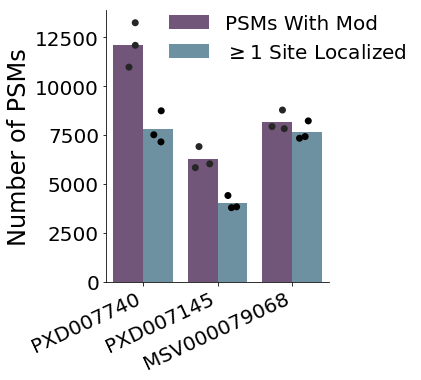

In [7]:
fig = plt.figure(figsize=[4, 5])

np.random.seed(4)
sns.barplot(data = score_counts,
            x="dataset",
            y="value",
            hue="stat",
            palette=["#461554", "#30708d"],
            alpha=.75,
            ci=None)

sns.stripplot(data = score_counts,
              x="dataset",
              y="value",
              hue="stat",
              color="black",
              dodge=True,
              jitter=.2,
              s=7)

plt.xlabel("")
plt.ylabel("Number of PSMs", size=24)
plt.tick_params(labelsize=20)
plt.xticks(rotation=25, ha='right')

handles, labels = fig.axes[0].get_legend_handles_labels()
plt.legend(handles[2:],
           ["PSMs With Mod", "$\geq$1 Site Localized"],
           fontsize=20,
           bbox_to_anchor=(0.2, 1.05),
           frameon=False)

sns.despine()
plt.savefig("figures/localized_psm_barplot.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

Interestingly, above we see that acetylation seems to localize more sites that phosphorylation. This is almost enirely due to the fact that there are typically much less acceptor sites for acetylation on a peptide.

### Check Acetylation data

As stated above, acetylation on the c-terminal lysine is almost garunteed not to happen. Thus, by counting how often this occures, we can get a first pass sense of the false localization rate of pyAscore.

In [8]:
acetyl = scores[scores["dataset"] == "MSV000079068"]
single_acetyl = acetyl[acetyl.LocalizedSequence.str.count("K\[42\]") == 1] # "K\[42\]"
single_acetyl = single_acetyl.copy()
single_acetyl["Ascores"] = single_acetyl["Ascores"].astype(float)
single_acetyl = single_acetyl[single_acetyl.Ascores < np.inf]
single_acetyl = single_acetyl.sort_values("Ascores", ascending=False)

single_acetyl["internalCount"] = single_acetyl.LocalizedSequence.str.count("K(\[[^A-Z]+\])?[A-Z]")
single_acetyl["hasCTermK"] = single_acetyl.LocalizedSequence.str.contains("K(\\[42\])?$")
single_acetyl = single_acetyl[np.logical_and(single_acetyl.internalCount >= 1, single_acetyl.hasCTermK)]

/tmp/287087378.1.villen-login.q/ipykernel_3499/426772791.py:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  single_acetyl["hasCTermK"] = single_acetyl.LocalizedSequence.str.contains("K(\\[42\])?$")


In [9]:
single_acetyl["cTermAcetyl"] = single_acetyl.LocalizedSequence.str.contains("K\[42\]$")
single_acetyl["cTermAcetylCount"] = np.cumsum(single_acetyl["cTermAcetyl"])
single_acetyl["flr"] = single_acetyl["cTermAcetylCount"] / np.arange(1, single_acetyl.shape[0] + 1)

Ascore 20 FLR: 0.007875894988066826


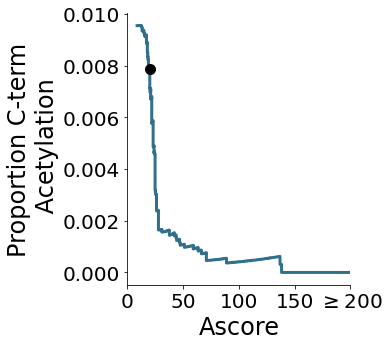

In [10]:
plt.figure(figsize=[4, 5])

select = single_acetyl.Ascores > 0.
plt.plot(single_acetyl[select].Ascores,
         single_acetyl[select].flr,
         lw=3,
         c="#30708d")

point = single_acetyl[single_acetyl.Ascores >= 20].iloc[-1]
print("Ascore 20 FLR: {}".format(point.flr))
plt.scatter(point.Ascores,
            point.flr,
            s=100,
            c="black",
            zorder=10)

plt.tick_params(labelsize=20)
plt.xlabel("Ascore", size=24)
plt.ylabel("Proportion C-term\n Acetylation",
           size=24)
plt.xlim(0, 200)
plt.xticks([0, 50, 100, 150, 200],
           ["0", "50", "100", "150", "$\geq$200"])

sns.despine()
plt.savefig("figures/cterm_acetylation_test.svg",
            bbox_inches="tight",
            facecolor="white")
plt.show()

The decreasing trend with increasing Ascore is exactly what we want to see and gives us confidence that pyAscore is doing what it is supposed to. In all, we can expect quite good performance from an Ascore cutoff of 20, and there doesn't seem to be much reason not to recommend it.